# OpenCV Image Registration

Rupert Thomas  
Jan 2021

Feature-based registration (SIFT, ORB)  
Iterative search correlation maximisation

## SIFT Features  

https://docs.opencv.org/master/db/d27/tutorial_py_table_of_contents_feature2d.html

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

img1 = cv.imread('box.png',0)          # queryImage
img2 = cv.imread('box_in_scene.png',0) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [ ]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

In [ ]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

## ORB Features

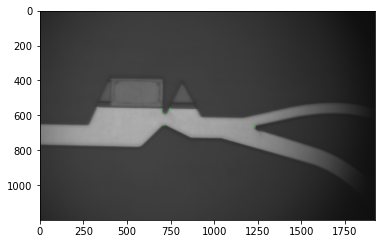

(<matplotlib.image.AxesImage at 0x20f2fe55520>, None)

In [8]:
# ORB

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('img2.png',0)
# print(img.shape)
# img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Initiate ORB detector
orb = cv.ORB_create()

# find the keypoints with ORB
kp = orb.detect(img,None)

# compute the descriptors with ORB
kp, des = orb.compute(img, kp)

# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

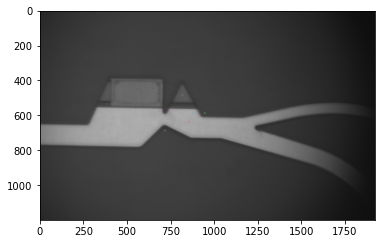

(<matplotlib.image.AxesImage at 0x20f30ee0730>, None)

In [46]:
import numpy as np
import cv2 as cv
img = cv.imread('img2.png')
# img = cv.imread('checkerboard1.jpg')
# img= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(img,None)
img=cv.drawKeypoints(img,kp,img)
plt.imshow(img), plt.show()
# cv.imwrite('sift_keypoints.jpg',img)

## ECC Iterative

https://stackoverflow.com/questions/45179304/brightness-contrast-correction-first-before-image-alignment-or-vice-versa

In [89]:
import os, sys
import cv2
from PIL import Image
import numpy as np

path = "C:\\Users\\xxxx\\Desktop\\"
path1 = "C:\\Users\\xxxx\\Desktop\\aligned\\"

def ecc_alignment(img1_path, img2_path, img2_substitute_path=None):

    # Read the images to be aligned
    im1 =  cv2.imread(img1_path)  # target image
    im2 =  cv2.imread(img2_path)  # image to warp
    if img2_substitute_path is not None:
        im2_output = cv2.imread(img2_substitute_path)  # use this instead of im2 in final warp
    else:
        im2_output = im2

    # Convert images to grayscale
    im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        
    # Specify the number of iterations.
    number_of_iterations = 50;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-2 # 1e-10;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    inputMask = None
    gaussFiltSize = 1
    (cc, warp_matrix) = cv2.findTransformECC(im1_gray, im2_gray, warp_matrix, warp_mode, criteria, inputMask, gaussFiltSize)


    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography 
        im2_aligned = cv2.warpPerspective (im2_output, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,
                          borderMode=cv2.BORDER_CONSTANT, 
                          borderValue=0)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2_output, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,
                          borderMode=cv2.BORDER_CONSTANT, 
                          borderValue=0);

    return im2_aligned
    #cv2.imwrite("img_aligned.png", im2_aligned )



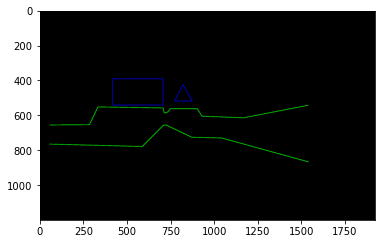

(<matplotlib.image.AxesImage at 0x20f40d88e20>, None)

In [90]:
img1_path = "img4.png"
img2_path = "silhouette1.png"
img2_substitute_path = "silhouette1_lines.png"

result = ecc_alignment(img1_path, img2_path, img2_substitute_path)

plt.imshow(result), plt.show()

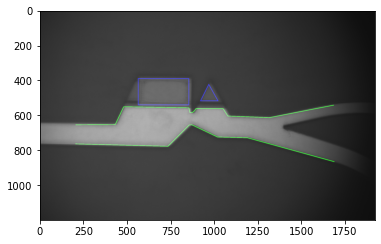

(<matplotlib.image.AxesImage at 0x20f40ed16a0>, None)

In [86]:
im1 =  cv2.imread(img1_path)

plt.imshow(cv2.bitwise_or(im1,result)), plt.show()